1. Text Prediction

[nltk_data] Downloading package gutenberg to
[nltk_data]     /Users/gemwincanete/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gemwincanete/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



=== Markov Chain Prediction ===
Sample prediction (deterministic): she was '' `` only think ! well , i am sure i have not
Sample prediction (creative): she was now , was threatening to a degree that could not be hoped from

=== LSTM Prediction ===


/Users/gemwincanete/Documents/Canete-Selerio_NLP_MODELS/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
4027/4027 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step - accuracy: 0.0462 - loss: 6.1976 - val_accuracy: 0.0957 - val_loss: 5.5405
Epoch 2/5
4027/4027 ━━━━━━━━━━━━━━━━━━━━ 49s 12ms/step - accuracy: 0.1072 - loss: 5.3559 - val_accuracy: 0.1192 - val_loss: 5.3099
Epoch 3/5
4027/4027 ━━━━━━━━━━━━━━━━━━━━ 49s 12ms/step - accuracy: 0.1253 - loss: 5.1002 - val_accuracy: 0.1289 - val_loss: 5.2295
Epoch 4/5
4027/4027 ━━━━━━━━━━━━━━━━━━━━ 48s 12ms/step - accuracy: 0.1333 - loss: 4.9359 - val_accuracy: 0.1366 - val_loss: 5.2140
Epoch 5/5
4027/4027 ━━━━━━━━━━━━━━━━━━━━ 47s 12ms/step - accuracy: 0.1437 - loss: 4.7948 - val_accuracy: 0.1432 - val_loss: 5.2203
Sample prediction (deterministic): she was afraid of the subject i can not have been in
Sample prediction (creative): she was ready of till we are full round jane fairfax or

Validation Perplexity: 114.29
BLEU-1 Score on Validation Set: 0.1521
BLEU-2 Score on Validation Set: 0.0481


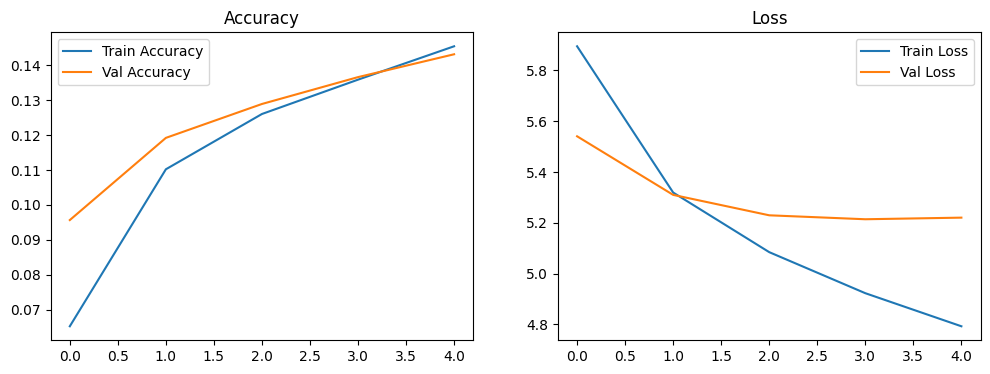

In [ ]:
import numpy as np
import random
from collections import defaultdict, Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Embedding, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import gutenberg
import matplotlib.pyplot as plt
import os
from nltk.tokenize import RegexpTokenizer  # Fallback tokenizer
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Set NLTK data path explicitly
nltk.data.path.append(os.path.expanduser("~/nltk_data"))

# Try to download resources
try:
    nltk.download('gutenberg')
    nltk.download('punkt')
except:
    print("NLTK download failed, using fallback tokenizer")

class TextPreprocessor:
    def __init__(self):
        self.tokenizer = Tokenizer()
        self.fallback_tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')

    def preprocess(self, text, min_word_freq=2):
        try:
            words = nltk.word_tokenize(text.lower())
        except LookupError:
            words = self.fallback_tokenizer.tokenize(text.lower())

        word_counts = Counter(words)
        filtered_words = [w for w in words if word_counts[w] >= min_word_freq]
        return ' '.join(filtered_words)

class MarkovChainPredictor:
    def __init__(self, n=3):
        self.n = n
        self.model = defaultdict(Counter)
        self.start_tokens = []

    def train(self, text):
        tokens = text.split()
        self.start_tokens = [tuple(tokens[i:i+self.n])
                            for i in range(0, len(tokens)-self.n, self.n)]

        for i in range(len(tokens) - self.n):
            *context, next_word = tokens[i:i+self.n+1]
            self.model[tuple(context)][next_word] += 1
        return tokens

    def predict(self, seed_text, num_words=20, temperature=1.0):
        tokens = seed_text.split()
        if len(tokens) < self.n:
            context = random.choice(self.start_tokens)
            tokens.extend(context)

        for _ in range(num_words):
            context = tuple(tokens[-self.n:])
            if context not in self.model:
                break

            words, counts = zip(*self.model[context].items())
            probs = np.array(counts) ** (1/temperature)
            probs /= probs.sum()

            next_word = np.random.choice(words, p=probs)
            tokens.append(next_word)

        return ' '.join(tokens)

class LSTMTextPredictor:
    def __init__(self, vocab_size=5000, max_len=20, embedding_dim=128):
        self.tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.model = self._build_model(embedding_dim)

    def _build_model(self, embedding_dim):
        model = Sequential([
            Embedding(self.vocab_size, embedding_dim, input_length=self.max_len-1),
            Bidirectional(LSTM(128, return_sequences=True)),
            Dropout(0.2),
            LSTM(64),
            Dense(self.vocab_size, activation='softmax')
        ])
        model.compile(loss='sparse_categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])
        return model

    def train(self, text, test_size=0.2, epochs=5):
        sequences = self._create_sequences(text)
        X, y = sequences[:, :-1], sequences[:, -1]
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size)
        early_stop = EarlyStopping(monitor='val_loss', patience=3)
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            callbacks=[early_stop],
            verbose=1
        )
        self.index_word = {v: k for k, v in self.tokenizer.word_index.items()} # Store index_word mapping
        return history

    def _create_sequences(self, text):
        self.tokenizer.fit_on_texts([text])
        sequences = []
        tokens = self.tokenizer.texts_to_sequences([text])[0]

        for i in range(1, len(tokens)):
            seq = tokens[max(0, i-self.max_len):i+1]
            sequences.append(seq)

        sequences = pad_sequences(sequences, maxlen=self.max_len, padding='pre')
        return sequences

    def predict(self, seed_text, num_words=20, temperature=1.0):
        for _ in range(num_words):
            token_seq = self.tokenizer.texts_to_sequences([seed_text])[0]
            token_seq = pad_sequences([token_seq[-self.max_len+1:]],
                                    maxlen=self.max_len-1,
                                    padding='pre')
            preds = self.model.predict(token_seq, verbose=0)[0]
            preds = np.log(preds + 1e-10) / temperature
            exp_preds = np.exp(preds)
            preds = exp_preds / np.sum(exp_preds)
            next_id = np.random.choice(len(preds), p=preds)
            next_word = self.index_word.get(next_id, '')
            seed_text += ' ' + next_word
        return seed_text

    def evaluate(self, text, test_size=0.2):
        sequences = self._create_sequences(text)
        X, y_true_indices = sequences[:, :-1], sequences[:, -1]
        X_train, X_val, y_true_train, y_true_val = train_test_split(X, y_true_indices, test_size=test_size, random_state=42)

        y_pred_probs = self.model.predict(X_val, verbose=0)
        y_pred_indices = np.argmax(y_pred_probs, axis=-1)

        # Calculate Perplexity on Validation Set
        val_loss = self.model.evaluate(X_val, y_true_val, verbose=0)
        perplexity = np.exp(val_loss[0])
        print(f"\nValidation Perplexity: {perplexity:.2f}")

        # Calculate BLEU scores (n-gram overlap)
        bleu_1_scores = []
        bleu_2_scores = []
        smoothing = SmoothingFunction().method1

        for i in range(len(y_true_val)):
            reference = [self.index_word.get(y_true_val[i])]
            candidate = [self.index_word.get(y_pred_indices[i])]
            if all(reference) and all(candidate): # Avoid issues with OOV words
                bleu_1_scores.append(sentence_bleu([reference], candidate, weights=(1, 0, 0, 0), smoothing_function=smoothing))
                bleu_2_scores.append(sentence_bleu([reference], candidate, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothing))

        if bleu_1_scores:
            print(f"BLEU-1 Score on Validation Set: {np.mean(bleu_1_scores):.4f}")
        else:
            print("BLEU-1 Score on Validation Set: Not applicable (no valid predictions)")

        if bleu_2_scores:
            print(f"BLEU-2 Score on Validation Set: {np.mean(bleu_2_scores):.4f}")
        else:
            print("BLEU-2 Score on Validation Set: Not applicable (no valid predictions)")

def plot_training_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

if __name__ == "__main__":
    # Load and preprocess data
    preprocessor = TextPreprocessor()
    text = gutenberg.raw('austen-emma.txt')
    processed_text = preprocessor.preprocess(text)

    print("\n=== Markov Chain Prediction ===")
    mc = MarkovChainPredictor(n=3)
    tokens = mc.train(processed_text)
    print("Sample prediction (deterministic):", mc.predict("she was", 10, temperature=0.5))
    print("Sample prediction (creative):", mc.predict("she was", 10, temperature=1.5))

    print("\n=== LSTM Prediction ===")
    lstm = LSTMTextPredictor(vocab_size=5000, max_len=20)
    history = lstm.train(processed_text)
    print("Sample prediction (deterministic):", lstm.predict("she was", 10, temperature=0.5))
    print("Sample prediction (creative):", lstm.predict("she was", 10, temperature=1.5))

    # Evaluation of LSTM model
    lstm.evaluate(processed_text)

    # Plot training history
    plot_training_history(history)

2. Sentiment Classification

[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/gemwincanete/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gemwincanete/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/gemwincanete/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/gemwincanete/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


=== Traditional Machine Learning Models ===

=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       300
           1       0.84      0.86      0.85       300

    accuracy                           0.85       600
   macro avg       0.85      0.85      0.85       600
weighted avg       0.85      0.85      0.85       600



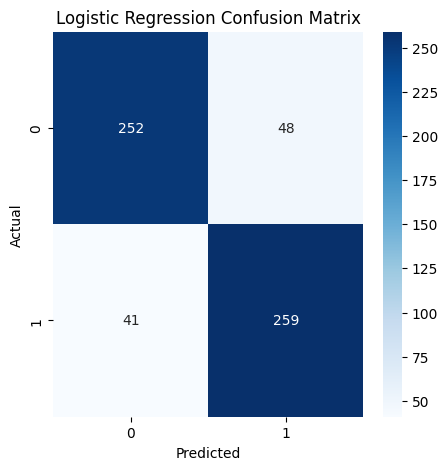


=== Traditional Model Predictions ===

Logistic Regression Predictions:
'This movie was absolutely fantastic! The acting wa...' -> Positive
'I've never seen such a terrible film in my life....' -> Positive
'The plot was average but the cinematography made u...' -> Negative
'Not worth the time or money....' -> Negative
'An instant classic that will stand the test of tim...' -> Positive

=== Deep Learning Model ===
Epoch 1/3


/Users/gemwincanete/Documents/Canete-Selerio_NLP_MODELS/venv/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 266ms/step - AUC: 0.4967 - accuracy: 0.5075 - loss: 0.7555 - val_AUC: 0.5550 - val_accuracy: 0.4357 - val_loss: 0.7467
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 250ms/step - AUC: 0.6148 - accuracy: 0.5792 - loss: 0.7357 - val_AUC: 0.6502 - val_accuracy: 0.5786 - val_loss: 0.7295
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 274ms/step - AUC: 0.8723 - accuracy: 0.8065 - loss: 0.5887 - val_AUC: 0.7255 - val_accuracy: 0.6643 - val_loss: 0.6785


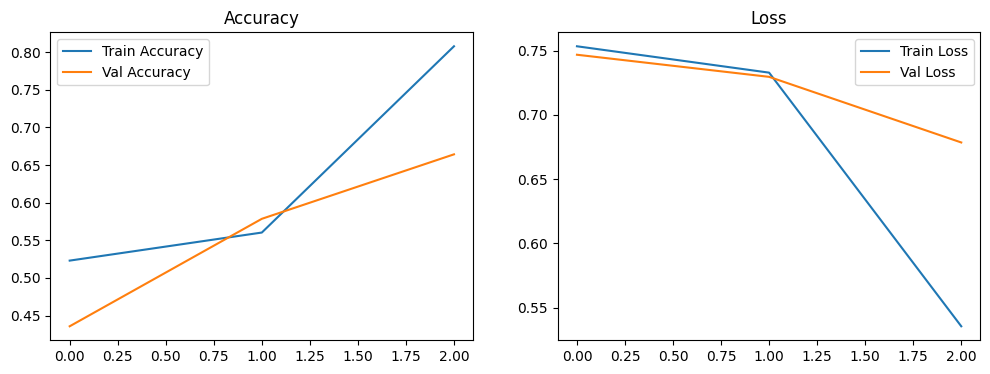

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

=== LSTM Classifier ===
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       300
           1       0.63      0.68      0.66       300

    accuracy                           0.64       600
   macro avg       0.64      0.64      0.64       600
weighted avg       0.64      0.64      0.64       600



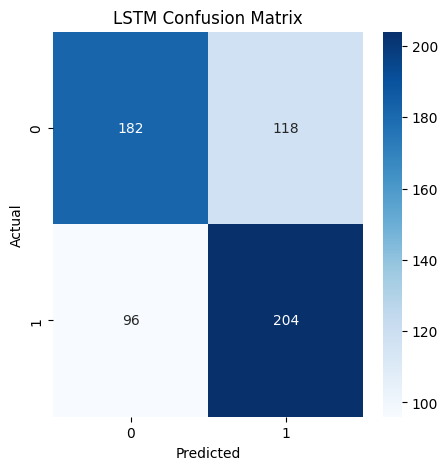


=== LSTM Predictions ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
'This movie was absolutely fantastic! The acting wa...' -> Negative
'I've never seen such a terrible film in my life....' -> Negative
'The plot was average but the cinematography made u...' -> Negative
'Not worth the time or money....' -> Negative
'An instant classic that will stand the test of tim...' -> Negative


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
import numpy as np
import nltk
from nltk.corpus import stopwords, movie_reviews
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns

# Set NLTK data path explicitly
nltk.data.path.append(os.path.expanduser("~/nltk_data"))

# Download NLTK data
nltk.download('movie_reviews')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
        self.stop_words = set(stopwords.words('english'))
    
    def preprocess_text(self, text):
        tokens = nltk.word_tokenize(text.lower())
        tokens = [self.lemmatizer.lemmatize(word) for word in tokens 
                 if word.isalpha() and word not in self.stop_words]
        return ' '.join(tokens)

def load_data():
    preprocessor = TextPreprocessor()
    texts = [' '.join(movie_reviews.words(fileid)) for fileid in movie_reviews.fileids()]
    labels = [1 if fileid.startswith('pos') else 0 for fileid in movie_reviews.fileids()]
    processed_texts = [preprocessor.preprocess_text(text) for text in texts]
    return processed_texts, np.array(labels)

# Traditional ML classifiers
def traditional_classifiers(X_train, X_test, y_train, y_test):
    classifiers = {
        'Logistic Regression': LogisticRegression(max_iter=1000),
    }
    
    # TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    results = {}
    for name, clf in classifiers.items():
        clf.fit(X_train_vec, y_train)
        y_pred = clf.predict(X_test_vec)
        acc = accuracy_score(y_test, y_pred)
        results[name] = acc
        print(f"\n=== {name} ===")
        print(classification_report(y_test, y_pred))
        
        # Plot confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    
    return results, vectorizer

def lstm_classifier(X_train, X_test, y_train, y_test):
    # Tokenization with OOV handling
    tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
    tokenizer.fit_on_texts(X_train)

    # Convert to sequences
    X_train_seq = tokenizer.texts_to_sequences(X_train)
    X_test_seq = tokenizer.texts_to_sequences(X_test)

    # Define max_len based on 95th percentile
    all_lengths = [len(seq) for seq in X_train_seq]
    max_len = int(np.percentile(all_lengths, 95))

    # Padding
    X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
    X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

    # Model architecture
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_length=max_len),
        Dropout(0.3),
        Bidirectional(LSTM(64, return_sequences=True)),
        Dropout(0.3),
        Bidirectional(LSTM(32)),
        Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', 'AUC']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        ModelCheckpoint('best_model.keras', save_best_only=True)
    ]

    history = model.fit(
        X_train_pad, y_train,
        validation_split=0.1,
        epochs=8,
        batch_size=64,
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

    # Evaluation
    y_pred = (model.predict(X_test_pad) > 0.5).astype(int)
    print("\n=== LSTM Classifier ===")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('LSTM Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    return model, tokenizer, history

# Main function
def main():
    # Load and preprocess data
    texts, labels = load_data()
    X_train, X_test, y_train, y_test = train_test_split(
        texts, labels, test_size=0.3, random_state=42, stratify=labels
    )
    
    # Test samples
    test_samples = [
        "This movie was absolutely fantastic! The acting was superb.",
        "I've never seen such a terrible film in my life.",
        "The plot was average but the cinematography made up for it.",
        "Not worth the time or money.",
        "An instant classic that will stand the test of time."
    ]
    
    # Traditional ML classifiers
    print("=== Traditional Machine Learning Models ===")
    ml_results, vectorizer = traditional_classifiers(X_train, X_test, y_train, y_test)
    
    # Test traditional models
    print("\n=== Traditional Model Predictions ===")
    test_vec = vectorizer.transform(test_samples)
    for name in ml_results.keys():
        clf = globals()[name.replace(' ', '')]
        model = Pipeline([('tfidf', vectorizer), ('clf', clf())])
        model.fit(X_train, y_train)
        preds = model.predict(test_samples)
        print(f"\n{name} Predictions:")
        for text, pred in zip(test_samples, preds):
            print(f"'{text[:50]}...' -> {'Positive' if pred == 1 else 'Negative'}")
    
    # LSTM classifier
    print("\n=== Deep Learning Model ===")
    lstm_model, tokenizer, history = lstm_classifier(X_train, X_test, y_train, y_test)
    
    # Test LSTM model
    print("\n=== LSTM Predictions ===")
    test_seq = tokenizer.texts_to_sequences(test_samples)
    test_pad = pad_sequences(test_seq, maxlen=100)
    predictions = (lstm_model.predict(test_pad) > 0.5).astype(int)
    for text, pred in zip(test_samples, predictions):
        print(f"'{text[:50]}...' -> {'Positive' if pred[0] == 1 else 'Negative'}")

if __name__ == "__main__":
    main()